In [1]:
import math
import json

import cv2

import numpy as np
import numpy.ma as ma

import scipy as scipy

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

import itertools

import tensorflow as tf

import keras
from keras import backend as K
from keras.utils import np_utils
from keras.engine import Layer

from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling2D, Deconvolution2D, UpSampling2D, Reshape, Flatten, ZeroPadding2D, BatchNormalization, Lambda, Dropout, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.models import Model, Sequential
from keras.models import model_from_json

from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image

from keras.callbacks import Callback
from keras.models import load_model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

#from vis.utils import utils
#from vis.visualization import visualize_saliency

from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
from keras.utils import to_categorical

from scipy.ndimage import zoom

import os

from sklearn.model_selection import train_test_split

from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

import random

from sklearn.utils import class_weight

import theano
import theano.tensor as T

from keras.regularizers import l2

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

theano.config.opennp = True



Using TensorFlow backend.


In [7]:
#Parameters (Modify as needed)
img_size_x = 110
img_size_y = 110
img_size_z = 110

batch_size = 10
classes = 2
epochs = 60
lr = 27*1e-6

early_stopping_patience = 20
class_names = ['NC', 'AD']

In [8]:
def load_dataset_clean():
    AD_directory = "/home/ubuntu/project/Data/AD_clean/"
    NC_directory = "/home/ubuntu/project/Data/NC_clean/"
    
    AD_list = os.listdir(AD_directory)
    NC_list = os.listdir(NC_directory)
    

    All_directory = "/home/ubuntu/project/Data/AD_NC_Clean/"

    X = np.zeros((111,img_size_x,img_size_y,img_size_z,1))
    Y = np.zeros(111)
    
    l = os.listdir(All_directory)
    random.shuffle(l)
   
    
    objindex = 0
    for i, filename in enumerate(l):
        if (filename.startswith('.')):
            print ("hidden file")
        else:
            epi_img = nib.load(All_directory + filename)
            x = epi_img.get_fdata()
            x = (x-x.min())/x.max()
            
            x = np.expand_dims(x, axis=3)
            X[objindex] = x
            y = 0
            if filename in AD_list:
                y = 1
                
            Y[objindex] = y
            
            objindex += 1
            
    return X, Y



In [9]:
X, Y = load_dataset_clean()

In [10]:
train_data = X[41:111]
train_labels = Y[41:111]
val_data = X[0:41] 
val_labels = Y[0:41] 

test_subj = X[70]
test_label = Y[70]

#test_data = X[205:245]
#test_labels = Y[205:245]

In [11]:
print (train_data.shape)
print (train_labels)

(70, 110, 110, 110, 1)
[1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]


In [12]:
print (val_labels)

[1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]


In [13]:
#Builds keras 3D CNN model
def build_cnn(dimension = '3d', activation = 'softmax', heatmap = False, w_path = None, compile_model = True):
    input_3d = (img_size_x, img_size_y, img_size_z, 1)
    
    #VoxCNN architecture
    
    model = Sequential()
    # 1st Volumetric Convolutional block
    model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same', input_shape=input_3d))
    model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 2nd Volumetric Convolutional block
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 3rd Volumetric Convolutional block
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 4th Volumetric Convolutional block
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    # 1th Deconvolutional layer with batchnorm and dropout for regularization
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    # 2th Deconvolutional layer
    model.add(Dense(64, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    # Output with softmax nonlinearity for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if w_path:
        model.load_weights(w_path)
    
    opt = keras.optimizers.Adam(lr)
    
    if(compile_model):
        model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    
    print ('Done building model.')

    return model

In [14]:
model = build_cnn(dimension = '3d', compile_model = True)

W1208 03:04:35.361014 139901362890496 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1208 03:04:35.381788 139901362890496 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1208 03:04:35.384937 139901362890496 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1208 03:04:35.613389 139901362890496 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The n

Done building model.


In [15]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 110, 110, 110, 8)  224       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 110, 110, 110, 8)  1736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 55, 55, 55, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 55, 55, 55, 16)    3472      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 55, 55, 55, 16)    6928      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 27, 27, 27, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 27, 27, 27, 32)    13856     
__________

In [16]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

roc_val_scores = []

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        roc_val_scores.append(round(roc_val,4))
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [17]:
# Fitting model architecture to data, also runs loss/accuracy tracker
def fit_model(model, v, train_data, train_labels, val_data, val_labels):
    roc_val_scores = []
    model_weights_file = 'img_classifier_weights_%s.h5' %v
    epoch_weights_file = 'img_classifier_weights_%s_{epoch:02d}_{val_acc:.2f}.hdf5' %v
    model_file = 'img_classifier_model_%s.h5' %v
    history_file = 'img_classifier_history_%s.json' %v
    
    def save_model_and_weights():
        model.save(model_file)
        model.save_weights(model_weights_file)
        
        return 'Saved model and weights to disk!'

    def save_model_history(m):
        with open(history_file, 'w', encoding="utf8") as history_json_file:
            json.dump(m.history, history_json_file)
        
        return 'Saved model history to disk!'
    
    def visualise_accuracy(m):
        plt.plot(m.history['acc'])
        plt.plot(m.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
      
    def visualise_loss(m):
        plt.plot(m.history['loss'])
        plt.plot(m.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.ylim(0,1.5)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    
    def model_callbacks():
        checkpoint = ModelCheckpoint(epoch_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
        
        roc = roc_callback(training_data=(train_data, train_labels),validation_data=(val_data,val_labels))
        
        return [checkpoint, roc]
        
    callbacks_list = model_callbacks()
    
    y_ints = [y.argmax() for y in train_labels]
    
    #class_weights = class_weight.compute_class_weight('balanced',
                                                 #np.unique(y_ints),
                                                 #y_ints)
    #print (class_weights)
    
    m = model.fit(train_data,train_labels,batch_size=batch_size, epochs=epochs, verbose=1,shuffle=True,validation_data=(val_data,val_labels),callbacks=callbacks_list)
    
    print (save_model_and_weights())
    print (save_model_history(m))
    
    visualise_accuracy(m)
    visualise_loss(m)
    
    return m

In [18]:
print(train_data.shape)
print(train_labels.shape)

(70, 110, 110, 110, 1)
(70,)


Train on 70 samples, validate on 41 samples
Epoch 1/60
70/70 [==============================] - 30s 430ms/step - loss: 0.6923 - acc: 0.5571 - val_loss: 0.6950 - val_acc: 0.4878

Epoch 00001: val_acc improved from -inf to 0.48780, saving model to img_classifier_weights_v1_01_0.49.hdf5
roc-auc: 0.6367 - roc-auc_val: 0.4                                                                                                    
Epoch 2/60
70/70 [==============================] - 18s 253ms/step - loss: 0.6897 - acc: 0.6000 - val_loss: 0.6927 - val_acc: 0.5122

Epoch 00002: val_acc improved from 0.48780 to 0.51220, saving model to img_classifier_weights_v1_02_0.51.hdf5
roc-auc: 0.7492 - roc-auc_val: 0.55                                                                                                    
Epoch 3/60
70/70 [==============================] - 18s 256ms/step - loss: 0.6866 - acc: 0.6429 - val_loss: 0.6910 - val_acc: 0.5122

Epoch 00003: val_acc did not improve from 0.51220
roc-auc: 0.745 -

70/70 [==============================] - 18s 260ms/step - loss: 0.5319 - acc: 0.7286 - val_loss: 1.8063 - val_acc: 0.5122

Epoch 00026: val_acc did not improve from 0.53659
roc-auc: 0.7183 - roc-auc_val: 0.6738                                                                                                    
Epoch 27/60
70/70 [==============================] - 18s 261ms/step - loss: 0.5726 - acc: 0.7571 - val_loss: 1.9772 - val_acc: 0.5122

Epoch 00027: val_acc did not improve from 0.53659
roc-auc: 0.715 - roc-auc_val: 0.6714                                                                                                    
Epoch 28/60
70/70 [==============================] - 18s 262ms/step - loss: 0.5629 - acc: 0.7286 - val_loss: 1.7257 - val_acc: 0.5122

Epoch 00028: val_acc did not improve from 0.53659
roc-auc: 0.7192 - roc-auc_val: 0.6833                                                                                                    
Epoch 29/60
70/70 [=========================

roc-auc: 0.9158 - roc-auc_val: 0.8                                                                                                    
Epoch 51/60
70/70 [==============================] - 18s 263ms/step - loss: 0.4337 - acc: 0.8429 - val_loss: 0.6309 - val_acc: 0.6829

Epoch 00051: val_acc did not improve from 0.78049
roc-auc: 0.9283 - roc-auc_val: 0.8119                                                                                                    
Epoch 52/60
70/70 [==============================] - 18s 263ms/step - loss: 0.3952 - acc: 0.8714 - val_loss: 0.7375 - val_acc: 0.5610

Epoch 00052: val_acc did not improve from 0.78049
roc-auc: 0.9692 - roc-auc_val: 0.8214                                                                                                    
Epoch 53/60
70/70 [==============================] - 18s 261ms/step - loss: 0.4029 - acc: 0.8429 - val_loss: 0.5428 - val_acc: 0.8049

Epoch 00053: val_acc improved from 0.78049 to 0.80488, saving model to img_classifie

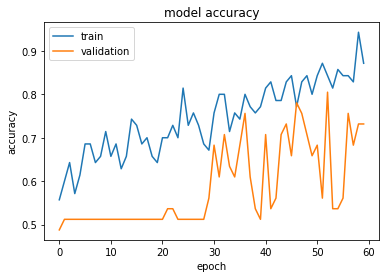

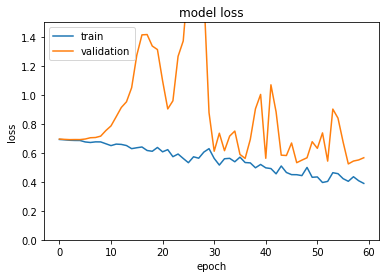

In [19]:
m = fit_model(model, "v1", train_data, train_labels, val_data, val_labels)

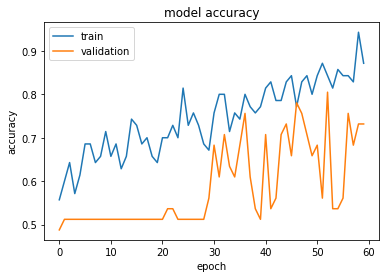

In [20]:
plt.plot(m.history['acc'])
plt.plot(m.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

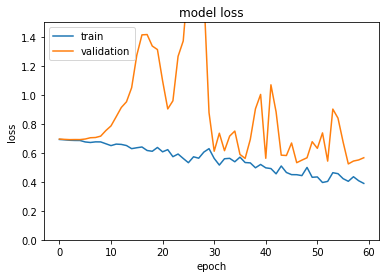

In [21]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0,1.5)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations

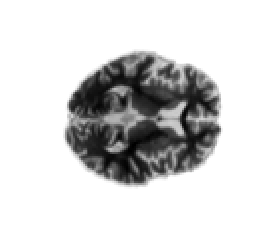

In [30]:
#W = np.array(get_activations(m, 1, test_subj))
#W = np.squeeze(W)
#test_subj = np.squeeze(test_subj)
#print (W.shape)
#w = W[5][14]
# w /= np.amax(w)
#w = scipy.misc.imresize(w, (img_size_x, img_size_y))
plt.figure()
jet_cmap = plt.cm.jet
# Get the colormap colors
heatmap = jet_cmap(np.arange(jet_cmap.N))
# Set alpha
heatmap[:,-1] = np.linspace(0, 1, jet_cmap.N)
# Create new colormap
heatmap = ListedColormap(heatmap)
plt.axis('off')
t = np.squeeze(test_subj)
plt.imshow(t[:, :, 55], interpolation='nearest', cmap=cm.binary)
plt.imshow(w, cmap=heatmap, alpha=.9, interpolation='bilinear')
plt.show()

In [31]:
def evaluate_model(m, weights, test_data, test_labels):    
     
    plt.close('all')

    m.load_weights(weights)
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print ("Done compiling model.")
    
    prediction = m.predict(test_data)
    #prediction_labels = np_utils.to_categorical(np.argmax(prediction, axis=1), nb_classes)
    
    #print (prediction)
    
    pred = []
    for p in prediction:
        if float(p[0]) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
    print (pred)
    
    print ('Accuracy on test data:', accuracy_score(test_labels, pred))

    print ('Classification Report')
    print (classification_report(test_labels, pred, target_names = ['NC', 'AD']))
    
    cm = confusion_matrix(test_labels,  pred)
    
    cm[0][1] = 1
    cm[1][0] = 2 
    print(cm)


    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

In [34]:
evaluate_model(model, 'img_classifier_weights_v1_53_0.80.hdf5', test_subj, test_label)

Done compiling model.


ValueError: Error when checking input: expected conv3d_1_input to have 5 dimensions, but got array with shape (110, 110, 110, 1)

In [22]:
print (roc_val_scores)

[0.4, 0.55, 0.5833, 0.5881, 0.6143, 0.65, 0.6381, 0.65, 0.6595, 0.6429, 0.6333, 0.6333, 0.6238, 0.6476, 0.65, 0.6548, 0.6571, 0.6333, 0.6548, 0.6667, 0.6619, 0.6595, 0.6571, 0.6571, 0.6714, 0.6738, 0.6714, 0.6833, 0.681, 0.7048, 0.7286, 0.7333, 0.7381, 0.7429, 0.75, 0.8024, 0.8214, 0.8, 0.7881, 0.7833, 0.8524, 0.7714, 0.7833, 0.8024, 0.8143, 0.7952, 0.8357, 0.8357, 0.831, 0.8, 0.8119, 0.8214, 0.8357, 0.7833, 0.8095, 0.8476, 0.8762, 0.8738, 0.8548, 0.8571]


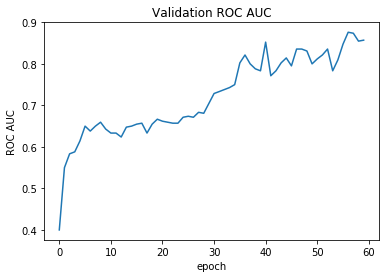

In [23]:
plt.plot(roc_val_scores)
plt.title('Validation ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('epoch')
plt.show()